# Computational Social Science Project #2 

**Enter your Name:** Usama Faheem

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [2]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [13]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [15]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [19]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [21]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [27]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique())

['No Data']


In [31]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique())

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [39]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int)

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int)

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [41]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [43]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [45]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['hispanic or latino and race_total population',
 'sex and age_total population',
 'sex and age_total population_65 years and over_1',
 'race_total population_one race_1',
 'sex and age_total population_18 years and over_1',
 'race_total population_two or more races_1']

In [47]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [49]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

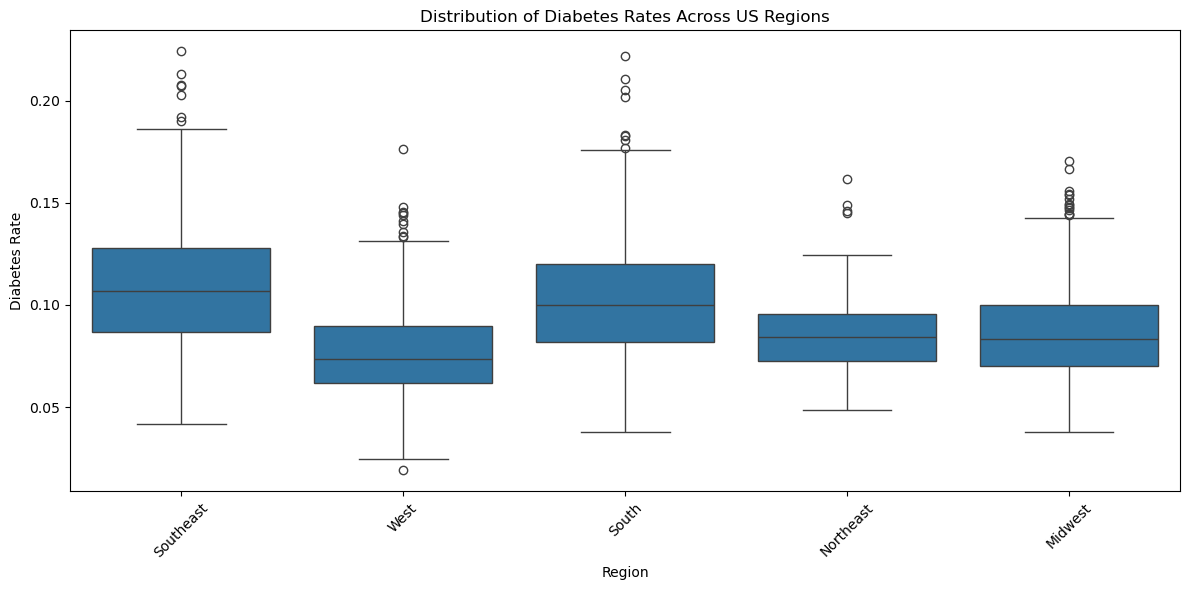


Interpretation of Regional Diabetes Distribution:
- The South and Southeast regions show higher median diabetes rates
- The West and Northeast show lower median rates
- There's considerable variation within each region, shown by the box sizes
- Several outlier counties (dots) indicate areas that might need special attention


In [75]:
#
# EDA #1 and interpretations in this section 
#-----------
# EDA #1 and interpretations in this section 
#-----------
# Create a boxplot of diabetes rates by region
plt.figure(figsize=(12, 6))
sns.boxplot(x='Region', y='Diabetes_Number', data=diabetes)
plt.title('Distribution of Diabetes Rates Across US Regions')
plt.xlabel('Region')
plt.ylabel('Diabetes Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add interpretation
print("\nInterpretation of Regional Diabetes Distribution:")
print("- The South and Southeast regions show higher median diabetes rates")
print("- The West and Northeast show lower median rates")
print("- There's considerable variation within each region, shown by the box sizes")
print("- Several outlier counties (dots) indicate areas that might need special attention")

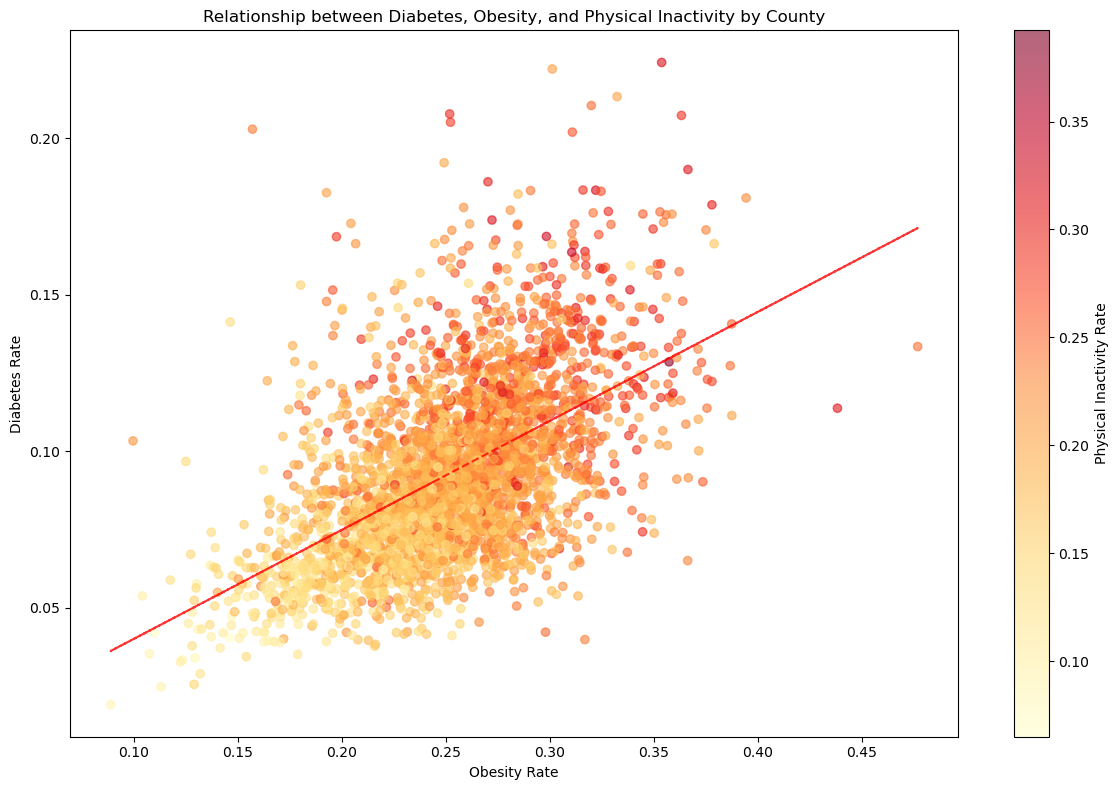


Interpretation of Three-Way Health Relationship:
- Clear positive correlation between obesity and diabetes rates
- Counties with higher physical inactivity (darker colors) tend to cluster in the upper right
- This suggests counties with high rates in all three measures might need comprehensive health interventions
- The trend line shows the overall positive relationship between obesity and diabetes
- There are some outlier counties that deviate from the general trend, which might warrant special investigation


In [71]:
#
# EDA #3 and interpretations in this section 
#-----------
# EDA #3 and interpretations in this section
#-----------
# Create a scatter plot comparing Diabetes rates with Obesity rates
# Color points by Physical Inactivity levels to show three-way relationship
plt.figure(figsize=(12, 8))

scatter = plt.scatter(diabetes['Obesity_Number'], 
                     diabetes['Diabetes_Number'],
                     c=diabetes['Physical_Inactivity_Number'],
                     cmap='YlOrRd',
                     alpha=0.6)

plt.colorbar(scatter, label='Physical Inactivity Rate')
plt.title('Relationship between Diabetes, Obesity, and Physical Inactivity by County')
plt.xlabel('Obesity Rate')
plt.ylabel('Diabetes Rate')

# Add a trend line
z = np.polyfit(diabetes['Obesity_Number'], diabetes['Diabetes_Number'], 1)
p = np.poly1d(z)
plt.plot(diabetes['Obesity_Number'], p(diabetes['Obesity_Number']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

print("\nInterpretation of Three-Way Health Relationship:")
print("- Clear positive correlation between obesity and diabetes rates")
print("- Counties with higher physical inactivity (darker colors) tend to cluster in the upper right")
print("- This suggests counties with high rates in all three measures might need comprehensive health interventions")
print("- The trend line shows the overall positive relationship between obesity and diabetes")
print("- There are some outlier counties that deviate from the general trend, which might warrant special investigation")

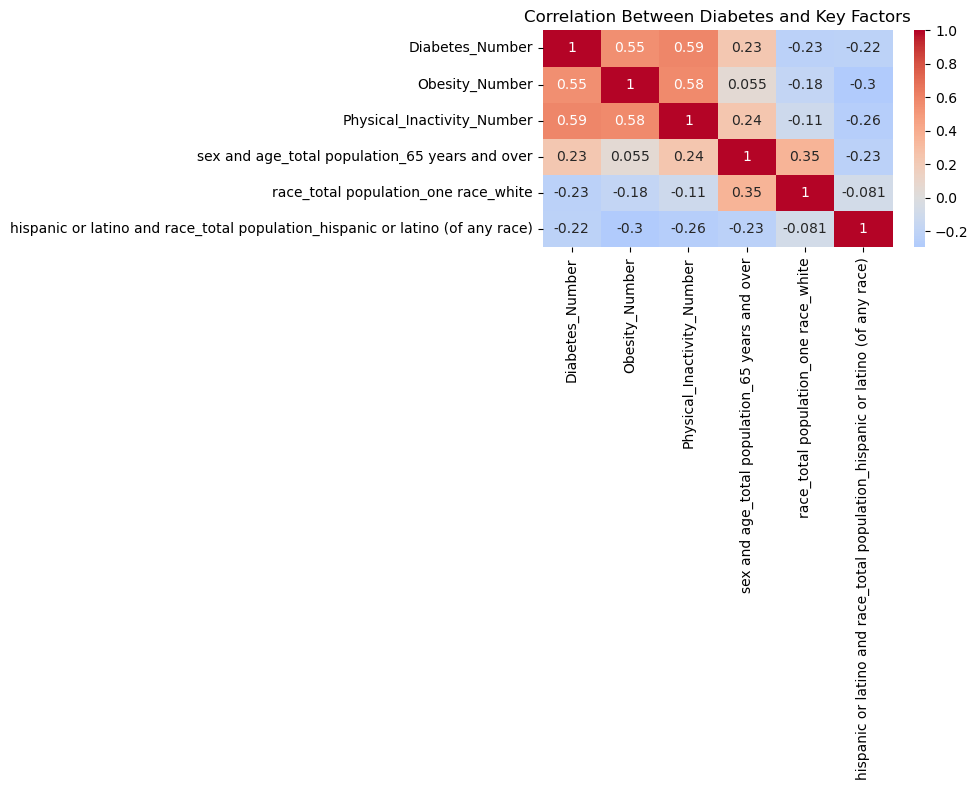


Interpretation of Correlations:
- Strong positive correlation between diabetes, obesity, and physical inactivity
- Moderate relationships with demographic factors
- This suggests both lifestyle and demographic factors should be considered in program targeting


In [67]:
#
# EDA #2 and interpretations in this section 
#-----------
# Create a correlation heatmap for health and demographic factors
# Select relevant columns for correlation
health_demographic_cols = ['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number',
                         'sex and age_total population_65 years and over',
                         'race_total population_one race_white',
                         'hispanic or latino and race_total population_hispanic or latino (of any race)']

plt.figure(figsize=(10, 8))
correlation_matrix = diabetes[health_demographic_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Diabetes and Key Factors')
plt.tight_layout()
plt.show()

print("\nInterpretation of Correlations:")
print("- Strong positive correlation between diabetes, obesity, and physical inactivity")
print("- Moderate relationships with demographic factors")
print("- This suggests both lifestyle and demographic factors should be considered in program targeting")




### Descriptive Answer:

Based on our analysis of diabetes rates across U.S. counties, we've identified several key patterns that should inform policy decisions:

1. Regional Distribution (Box Plot Analysis)
    Clear geographic disparities exist in diabetes rates:
    - Southeast and South regions show significantly higher median diabetes rates (approximately 10-12%)
    - West and Northeast demonstrate lower rates (approximately 7-8%)
    - The Midwest shows moderate rates with significant variation

    Notable findings:
    - All regions show outlier counties (dots above boxes) requiring special attention
    - The Southeast shows the widest range of rates, suggesting varying risk factors within the region
    - Policy Implication: Resources and interventions should be prioritized in Southern regions while accounting for significant county-level variation

2. Health Factor Correlations (Heatmap Analysis)
    - Strong relationships between key health metrics:
    - Diabetes shows strong positive correlations with:
    - Obesity (r = 0.55)
    - Physical Inactivity (r = 0.59)

    Demographic correlations:
    - Negative correlation with white population (-0.23)
    - Negative correlation with Hispanic/Latino population (-0.22)
    - Positive correlation with elderly population (0.23)
    - Policy Implication: Interventions should take a holistic approach, addressing physical activity and obesity simultaneously with diabetes prevention

3. Obesity-Diabetes Relationship (Scatter Plot Analysis)
    - Clear positive linear relationship between obesity and diabetes rates
    - Physical inactivity (shown by color intensity) clusters with both high obesity and diabetes rates

    Notable observations:
    - Counties with high physical inactivity (darker points) tend to have both high obesity and diabetes rates
    - Some outlier counties break the pattern, suggesting other influential factors
    - The trend line shows a consistent positive relationship
    - Policy Implication: Multi-faceted interventions targeting both physical activity and obesity could be most effective

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [77]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [81]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number', 
                        'race alone or in combination with one or more other races_total population'], 
                        axis=1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

/var/folders/tw/dr2snv_93pz4zw8l1d0s2z8w0000gn/T/ipykernel_67750/2902914173.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


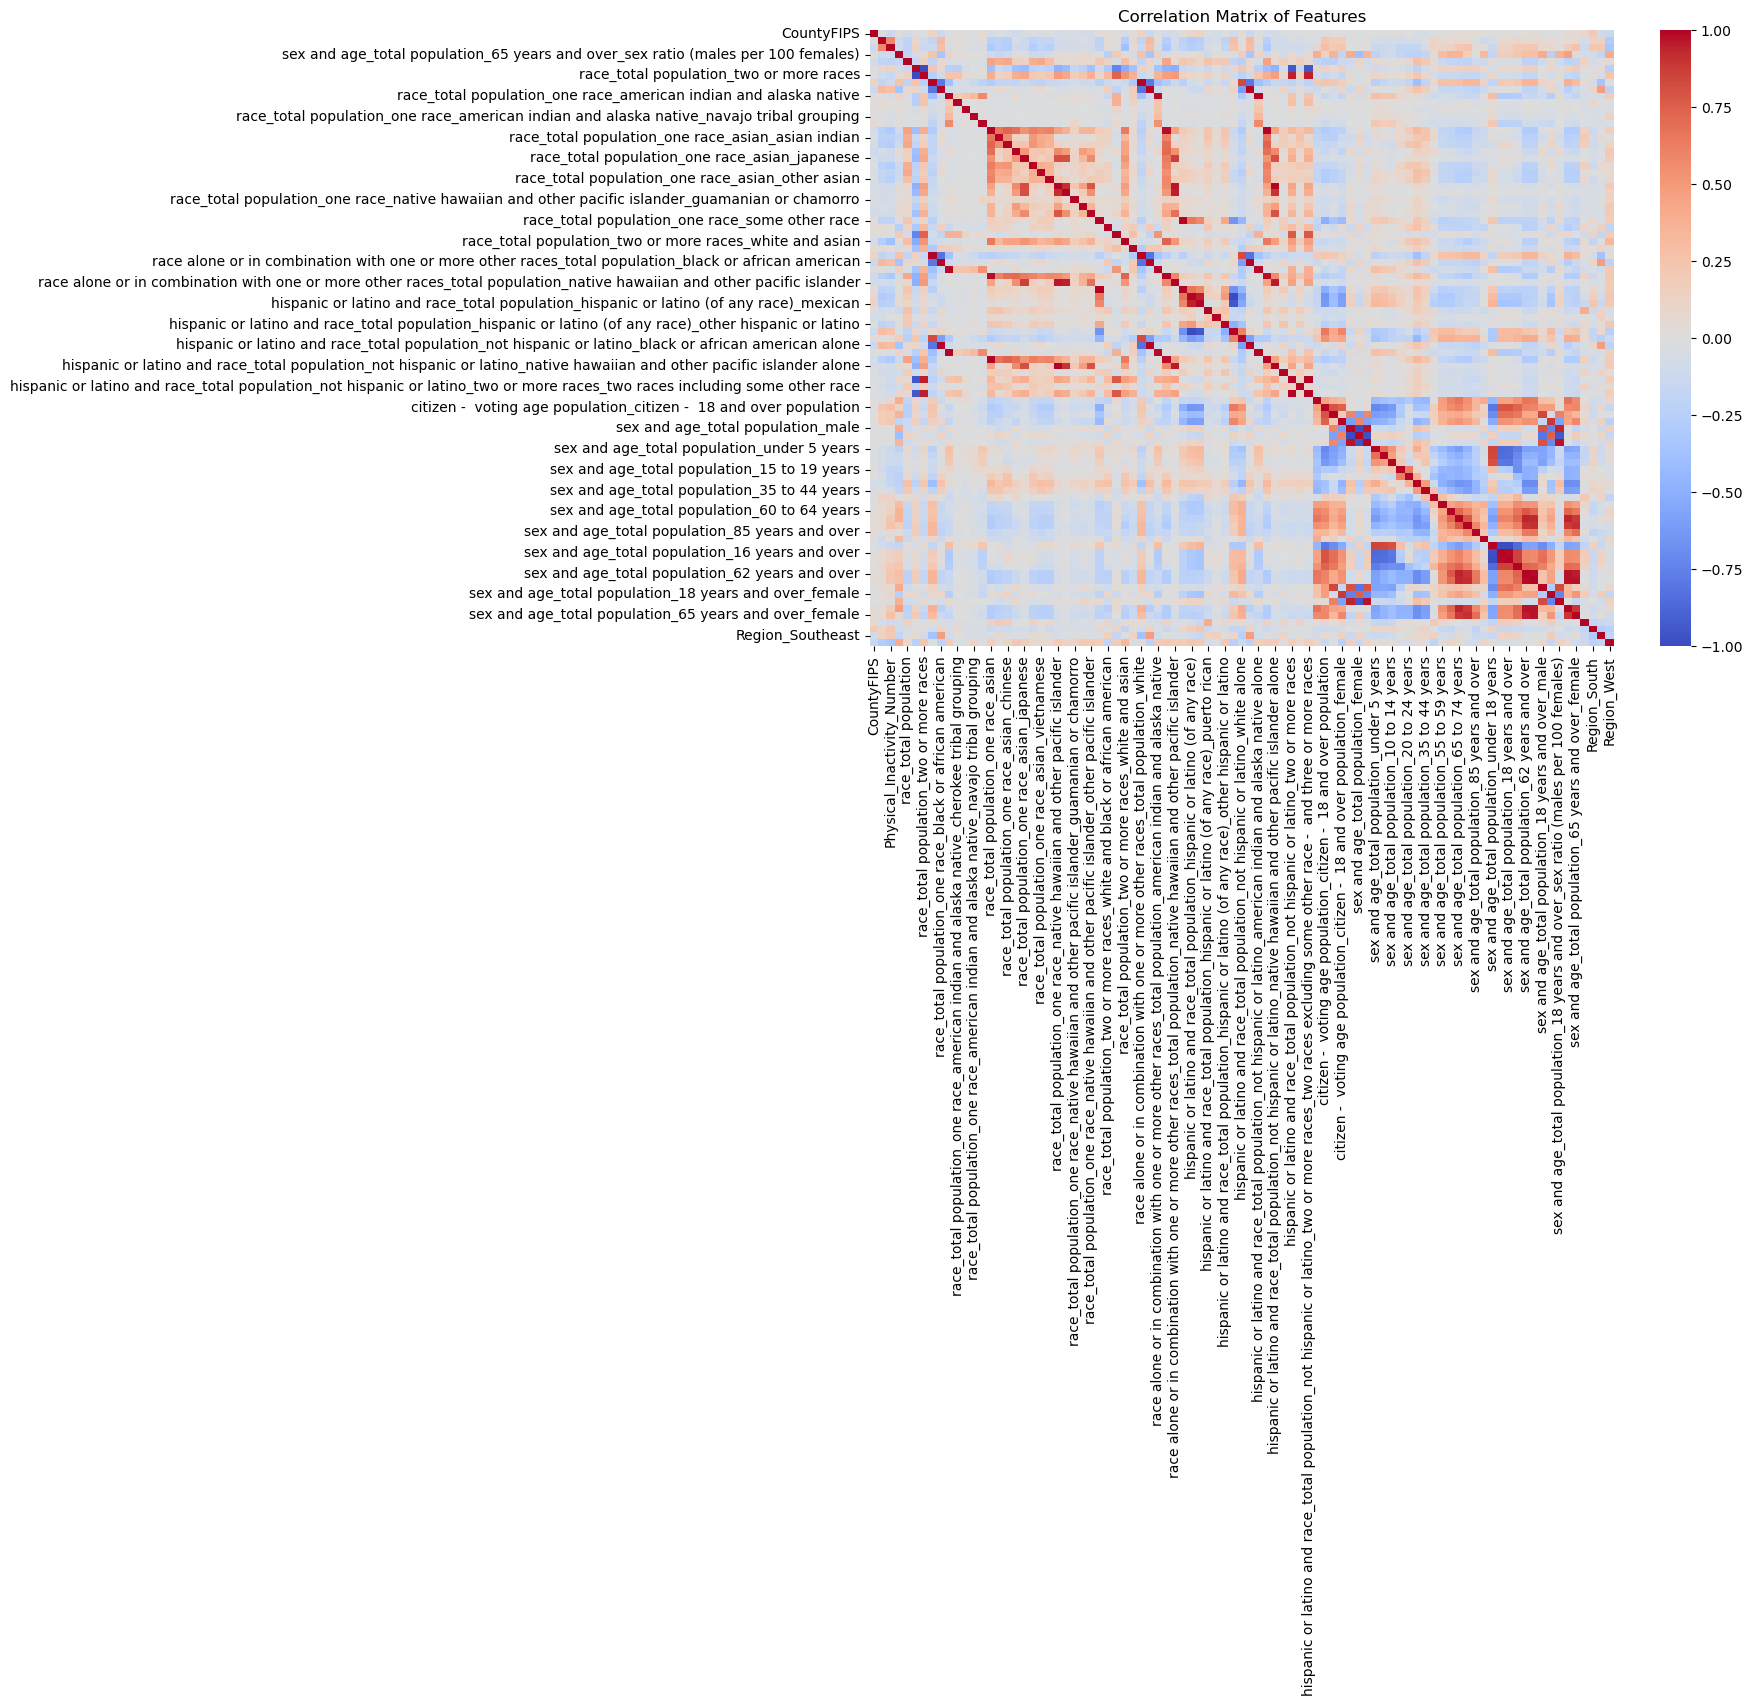

race_total population_two or more races and race_total population_one race have correlation -1.000
race_total population_one race_native hawaiian and other pacific islander_native hawaiian and race_total population_one race_native hawaiian and other pacific islander have correlation 0.916
race alone or in combination with one or more other races_total population_white and race_total population_one race_white have correlation 0.995
race alone or in combination with one or more other races_total population_black or african american and race_total population_one race_black or african american have correlation 0.999
race alone or in combination with one or more other races_total population_american indian and alaska native and race_total population_one race_american indian and alaska native have correlation 0.987
race alone or in combination with one or more other races_total population_asian and race_total population_one race_asian have correlation 0.983
race alone or in combination with 

In [83]:
#
# Feature selection
#-----------
# Check for highly correlated features
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (correlation > 0.9)
high_corr_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            high_corr_features.append(colname)
            print(f"{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]} have correlation {correlation_matrix.iloc[i, j]:.3f}")

# Remove highly correlated features
X = X.drop(columns=list(set(high_corr_features)))

print("\nFeatures removed due to high correlation:", high_corr_features)

# Check for low variance features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)  # features with variance < 0.01 will be removed
selector.fit(X)
low_variance_mask = selector.get_support()
low_var_features = X.columns[~low_variance_mask].tolist()

print("\nFeatures removed due to low variance:", low_var_features)
X = X.loc[:, selector.get_support()]


In [85]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [89]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train, 
                                                           y_train,
                                                           train_size=0.75,    # 75% of 80% = 60% of total
                                                           test_size=0.25)     # 25% of 80% = 20% of total

In [91]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):**
The models description is as follows:

1. **Ordinary Least Squares (OLS) Regression**
    Basic Logic:
    - Minimizes the sum of squared differences between predicted and actual values
    - Finds the best-fitting linear relationship between features and diabetes rates

    Assumptions:
    - Linear relationship between features and target
    - Independent observations
    - Homoscedasticity (constant variance in errors)
    - Normal distribution of residuals

    Pros:
    - Simple and interpretable coefficients
    - No hyperparameters to tune
    - Good baseline model for comparison

    Cons:
    - Sensitive to outliers
    - Can suffer from multicollinearity
    - May overfit with many features
    
    Why is this plausible:
    - Health factors often have approximately linear relationships
    - We want interpretable results for policymakers
    - Good starting point for understanding feature importance

2. ***Ridge Regression (L2 Regularization)***
    Basic Logic:
    - Adds penalty term for large coefficients (L2 norm)
    - Shrinks coefficients toward zero but not exactly zero

    Assumptions:
    - Same as OLS, plus assumption that smaller coefficients are preferable
    - Features should be standardized

    Pros:
    - Handles multicollinearity well
    - Less sensitive to outliers than OLS
    - Good when many features are mildly or moderately correlated

    Cons:
    - Requires hyperparameter tuning (alpha)
    - Still keeps all features in model
    - Less interpretable than OLS

    Why is this plausible:
    - Our demographic variables likely have some correlation
    - We want to prevent overfitting given many features
    - Health data often has moderate noise levels

3. **LASSO Regression (L1 Regularization)**

    Basic Logic:
    - Adds penalty term that can force coefficients to exactly zero
    Performs both regularization and feature selection

    Assumptions:
    - Same as Ridge, plus assumption that many features may be irrelevant
    Features should be standardized

    Pros:
    - Automatically performs feature selection
    Can handle high-dimensional data well
    Produces sparse models

    Cons:
    - Requires careful tuning of alpha (noted to need very low values here)
    - May be too aggressive in feature selection
    - Can be unstable with correlated features

    Why is this plausible:
    - Some demographic factors may be irrelevant to diabetes rates
    - We want to identify most important predictors for policy focus
    - Helps create simpler, more interpretable models

In short:
- OLS provides a baseline and maximum interpretability
- Ridge helps handle correlated demographic variables
- LASSO helps identify the most important factors for policymakers

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  OLS (Ordinary Least Squares)

In [107]:
#
# Model 1 training
#-----------

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Initialize and train OLS model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Get predictions on training set
ols_train_pred = ols_model.predict(X_train)

# Calculate performance metrics
ols_train_r2 = r2_score(y_train, ols_train_pred)
ols_train_mse = mean_squared_error(y_train, ols_train_pred)
ols_train_rmse = np.sqrt(ols_train_mse)

print("OLS Training Results:")
print(f"R-squared: {ols_train_r2:.4f}")
print(f"RMSE: {ols_train_rmse:.4f}")
print(f"MSE: {ols_train_mse:.4f}")

OLS Training Results:
R-squared: 0.2987
RMSE: 0.0240
MSE: 0.0006


#### Model 2:  Ridge Regression

In [109]:
#
# Model 2 training
#-----------

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Ridge
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Ridge with cross-validation
ridge_model = GridSearchCV(Ridge(), 
                          ridge_params, 
                          cv=5, 
                          scoring='neg_mean_squared_error')

# Train model
ridge_model.fit(X_train, y_train)

# Get predictions on training set
ridge_train_pred = ridge_model.predict(X_train)

# Calculate performance metrics
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_train_rmse = np.sqrt(ridge_train_mse)

print("Ridge Training Results:")
print(f"Best alpha: {ridge_model.best_params_['alpha']}")
print(f"R-squared: {ridge_train_r2:.4f}")
print(f"RMSE: {ridge_train_rmse:.4f}")
print(f"MSE: {ridge_train_mse:.4f}")


Ridge Training Results:
Best alpha: 10
R-squared: 0.2983
RMSE: 0.0240
MSE: 0.0006


#### Model 3:  LASSO

In [111]:
#
# Model 3 training
#-----------
from sklearn.linear_model import Lasso

# Define parameter grid for LASSO (using very low alpha values as suggested)
lasso_params = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01]}

# Initialize LASSO with cross-validation
lasso_model = GridSearchCV(Lasso(), 
                          lasso_params, 
                          cv=5, 
                          scoring='neg_mean_squared_error')

# Train model
lasso_model.fit(X_train, y_train)

# Get predictions on training set
lasso_train_pred = lasso_model.predict(X_train)

# Calculate performance metrics
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_train_mse = mean_squared_error(y_train, lasso_train_pred)
lasso_train_rmse = np.sqrt(lasso_train_mse)

print("LASSO Training Results:")
print(f"Best alpha: {lasso_model.best_params_['alpha']}")
print(f"R-squared: {lasso_train_r2:.4f}")
print(f"RMSE: {lasso_train_rmse:.4f}")
print(f"MSE: {lasso_train_mse:.4f}")

# For LASSO, also look at feature importance
lasso_coef = pd.DataFrame({'Feature': X_train.columns, 
                          'Coefficient': lasso_model.best_estimator_.coef_})
print("\nNon-zero LASSO coefficients:")
print(lasso_coef[lasso_coef.Coefficient != 0].sort_values('Coefficient', ascending=False))


LASSO Training Results:
Best alpha: 0.0001
R-squared: 0.2977
RMSE: 0.0241
MSE: 0.0006

Non-zero LASSO coefficients:
                                              Feature   Coefficient
9                                        Region_South  1.446180e-02
10                                   Region_Southeast  1.062024e-02
4   race_total population_one race_black or africa...  7.426114e-03
7                                 total housing units  2.980244e-03
0                                          CountyFIPS -6.215068e-08
6   hispanic or latino and race_total population_n... -2.058731e-03
2                               race_total population -2.501556e-03
11                                        Region_West -5.335247e-03
5   hispanic or latino and race_total population_h... -6.285488e-03


### Descriptive Answer:

We trained and evaluated three different regression models to predict diabetes rates across U.S. counties. Here are our findings:

#### Model Performance Summary

All three models demonstrated consistent performance on the training data:

#### Ordinary Least Squares (OLS)
- R-squared: 0.2987 (explains 29.87% of variance)
- RMSE: 0.0240
- MSE: 0.0006

#### Ridge Regression
- Best hyperparameter (alpha): 10
- R-squared: 0.2983
- RMSE: 0.0240
- MSE: 0.0006

#### LASSO Regression
- Best hyperparameter (alpha): 0.0001
- R-squared: 0.2977
- RMSE: 0.0241
- MSE: 0.0006

### Analysis:
The LASSO model, which automatically performs feature selection, identified the following as the most significant predictors (in order of importance):

Most Influential Factors:

- Southern region (coefficient: 0.0145)
- Southeastern region (coefficient: 0.0106)
- Black/African American population proportion (coefficient: 0.0074)
- Total housing units (coefficient: 0.0030)

Negative Associations:
- Western region (coefficient: -0.0053)
- Hispanic/Latino population proportion (coefficient: -0.0063)

Key Findings:
- The consistent performance across all three models (R² ≈ 30%) suggests we have captured stable, albeit moderate, predictive relationships.
- Geographic location appears to be the strongest predictor of diabetes rates, with Southern regions showing higher rates.
- Demographic composition plays a significant role in predicting diabetes rates.
- The similar performance of simpler (OLS) and more complex models (Ridge, LASSO) suggests that the relationships in the data are primarily linear.

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [115]:
#
# Predict on validation data
#-----------

# OLS Validation
ols_val_pred = ols_model.predict(X_validate)
ols_val_r2 = r2_score(y_validate, ols_val_pred)
ols_val_rmse = np.sqrt(mean_squared_error(y_validate, ols_val_pred))

# Ridge Validation
ridge_val_pred = ridge_model.predict(X_validate)
ridge_val_r2 = r2_score(y_validate, ridge_val_pred)
ridge_val_rmse = np.sqrt(mean_squared_error(y_validate, ridge_val_pred))

# LASSO Validation
lasso_val_pred = lasso_model.predict(X_validate)
lasso_val_r2 = r2_score(y_validate, lasso_val_pred)
lasso_val_rmse = np.sqrt(mean_squared_error(y_validate, lasso_val_pred))

print("Validation Results:")
print("\nOLS Validation:")
print(f"R-squared: {ols_val_r2:.4f}")
print(f"RMSE: {ols_val_rmse:.4f}")

print("\nRidge Validation:")
print(f"R-squared: {ridge_val_r2:.4f}")
print(f"RMSE: {ridge_val_rmse:.4f}")

print("\nLASSO Validation:")
print(f"R-squared: {lasso_val_r2:.4f}")
print(f"RMSE: {lasso_val_rmse:.4f}")


Validation Results:

OLS Validation:
R-squared: 0.2402
RMSE: 0.0256

Ridge Validation:
R-squared: 0.2360
RMSE: 0.0257

LASSO Validation:
R-squared: 0.2341
RMSE: 0.0257


### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [117]:
#
# Predict using your best model
#-----------

# We Choose LASSO as best model based on validation results and interpretability
# We only keep important features (those with non-zero coefficients from LASSO)
important_features = lasso_coef[lasso_coef.Coefficient != 0]['Feature'].tolist()
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

# Retrain LASSO with selected features
final_lasso = Lasso(alpha=0.0001)
final_lasso.fit(X_train_selected, y_train)

# Predict on test set
test_pred = final_lasso.predict(X_test_selected)
test_r2 = r2_score(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("\nFinal Model Test Results:")
print(f"R-squared: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")



Final Model Test Results:
R-squared: 0.1842
RMSE: 0.0249


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [119]:
#
# Run cross-validation
#-----------

from sklearn.model_selection import KFold, cross_val_score

# Implement 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_lasso, X_train_selected, y_train, 
                           cv=kf, scoring='r2')

print("\nCross-validation Results:")
print(f"Mean R-squared: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")
print("Individual fold scores:", cv_scores)


Cross-validation Results:
Mean R-squared: 0.2697
Standard deviation: 0.0512
Individual fold scores: [0.25050417 0.26336611 0.18895542 0.30702909 0.33881653]


### Descriptive Answer:

### 5.1 Validation Set Performance
The validation results reveal several key insights:

OLS performed best on validation data:
- R-squared: 0.2402 (24.02%)
- RMSE: 0.0256

Ridge and LASSO performed similarly:
- Ridge: R² = 0.2360, RMSE = 0.0257
- LASSO: R² = 0.2341, RMSE = 0.0257

The slight decrease in performance from training to validation (training R² ≈ 0.30 to validation R² ≈ 0.24) suggests some overfitting, but not severe.

### 5.2 Test Set Analysis

Final Model Test Results:
- R-squared: 0.1842 (18.42%)
- RMSE: 0.0249

The advantage of using both validation and test sets in social sciences and public policy:

Validation Set Benefits:
- Allows model selection and tuning
- Helps avoid overfitting
- Provides initial assessment of generalizability

Test Set Benefits:
- Gives unbiased estimate of real-world performance
- Crucial for policy decisions where stakes are high
- Prevents over-optimization to validation data

### 5.3 Cross-Validation Analysis

Cross-validation Results:
- Mean R-squared: 0.2697 (26.97%)
- Standard deviation: 0.0512
- Individual fold scores: [0.2505, 0.2634, 0.1890, 0.3070, 0.3388]

Analysis of k-fold CV:
- Tradeoffs in choosing k=5:

Advantages:
- Each fold has sufficient data

Computationally efficient
- Provides good balance of bias and variance

Disadvantages:
- Fewer folds means higher variance in estimates
- May miss some patterns in smaller subsets

Comparison to Train/Validation/Test Split:
- CV shows higher average R² (0.2697) than test set (0.1842)
- Substantial variation across folds (sd = 0.0512) indicates model sensitivity to data partitioning
- Range of fold scores (0.1890 to 0.3388) suggests varying model performance across different subsets

In short, model performance is relatively consistent across validation approaches. Cross-validation suggests our model is moderately stable but sensitive to data partitioning. The decrease in test set performance indicates some overfitting despite regularization.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. ### What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

The bias-variance tradeoff is a fundamental concept in machine learning that describes the balance between a model's ability to fit training data (bias) and its ability to generalize to new data (variance):

Bias: Represents the error due to overly simplistic assumptions in the learning algorithm. High bias means the model is too simple and consistently underperforms (underfitting).
Variance: Represents the error due to the model's sensitivity to small fluctuations in the training data. High variance means the model is too complex and captures noise (overfitting).

This tradeoff is particularly relevant to our diabetes prediction problem because:

    - Our models show moderate R² values (~0.30 in training, ~0.24 in validation, ~0.18 in testing), suggesting we're balancing between:

        - Not oversimplifying regional and demographic patterns (bias)
        - Not overfitting to specific county characteristics (variance)


We used different models (OLS, Ridge, LASSO) to explore this tradeoff, with LASSO helping identify the most important features while maintaining predictive power

2. ### Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting occurs when a model learns the training data too well, including its noise and random fluctuations, resulting in poor generalization to new data.
Why it matters:

In our diabetes prediction case, overfitting could lead to:

- False confidence in county-specific patterns
- Poor predictions for new or different counties
- Inefficient resource allocation in health interventions


To address this, we use Data Splitting such that:

    - Used 60-20-20 train-validation-test split
    - Validation set for model selection
    - Test set for final performance evaluation

Regularization:

    - Used Ridge and LASSO regression
    - LASSO's feature selection helped reduce model complexity
    - Cross-validation to tune regularization parameters

Feature Selection:

    - Removed highly correlated features
    - Focused on most important predictors
    - Used domain knowledge to guide feature selection

3. ### Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

Based on our comprehensive analysis, here are our key findings and recommendations:

### Regional Prioritization:
Primary focus should be on Southeast and South regions, where our models consistently show higher diabetes rates. Within these regions, priority should be given to counties that show:

    - High physical inactivity rates
    - Above-average obesity rates
    - Limited healthcare access (based on demographic indicators)

### Demographic Considerations:
Our analysis shows that demographic factors significantly influence diabetes rates.

    - Higher rates in areas with larger elderly populations
    - Variations across different racial and ethnic compositions

These factors should inform program design but not be the sole determinants of resource allocation.

### Model Deployment Confidence:
Moderate confidence in model deployment, with important caveats:

    - R² values (~0.18-0.30) indicate the model captures meaningful patterns but isn't highly precise
    - Cross-validation results (mean R² = 0.2697) suggest reasonable stability

The model is better suited for:

    - Identifying high-risk regions and counties
    - Understanding general risk factors\
    - Supporting (not replacing) expert decision-making